# Analyzing the NYC Subway Dataset

Craig Nicholson
September 9th 2015

In this notebook, we will review look the NYC Subway data and determine if more people ride the subway when it is raining versus when it is not raining.

## Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import SGDRegressor

In [2]:
# display plot within the notebook rather than a new window
%pylab inline


Populating the interactive namespace from numpy and matplotlib


## Load the Data

In [3]:
# load the stroopdata.csv
path = '~/Downloads/P2-1/turnstile_weather_v2.csv'
df = pd.read_csv(path)

In [4]:
# fetch two samples, the one with rain and the one without rain
# 1 = rain, 0 = no rain for the entry
# reset the indexes since we have new dataframes
rain = df[df['rain']==1].reset_index()
norain =  df[df['rain']==0].reset_index()

## Calculations

In [5]:
'''
 The Mann-Whitney U test is used to compare differences between two independent groups 
 when the dependent variable is either ordinal or continuous, but not normally distributed. 
 
 Returns The Mann-Whitney statistics, p-value (one sided)
 Mann-Whitney U is significant if the u-obtained is LESS THAN or equal to the critical value of U
 
 Hard to figure out U critical value
 http://www.real-statistics.com/statistics-tables/mann-whitney-table/
 http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Nonparametric/BS704_Nonparametric4.html
 
 Mann-Whitney U test can be applied on unknown distributions contrary to t-test which has to be applied 
 only on normal distributions, and it is nearly as efficient as the t-test on normal distributions.
 
 https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test
'''
u_statistic, mannwhitney_p_value = stats.mannwhitneyu(rain['ENTRIESn_hourly'], norain['ENTRIESn_hourly']
                                                      , use_continuity=True)
print 'Mann-Whitney U test \nU statistic: %.3f \np-value (1 sided): %.9f\np-value (2-sided): %.9f' % (u_statistic, mannwhitney_p_value, 2*mannwhitney_p_value)

Mann-Whitney U test 
U statistic: 153635120.500 
p-value (1 sided): 0.000002741
p-value (2-sided): 0.000005482


In [6]:
'''
 t-test via scipy
 returns t-statistic and two-tailed p-value
 equal_var = False, perform Welch’s t-test, which does not assume equal population 
 Welch does not assume equal sample size or equal variances
 equal_var = True - returns 5.33
'''
t_test_results = stats.ttest_ind(rain['ENTRIESn_hourly'],norain['ENTRIESn_hourly']
                                 ,equal_var = False)
t_statistic = t_test_results[0]
p_value = t_test_results[1]
print'Welch''s T-test (Independent T-test) equal_var=False\nT-statistic: %.3f\tp-value: %.8f' % (t_statistic, p_value)

Welchs T-test (Independent T-test) equal_var=False
T-statistic: 5.043	p-value: 0.00000046


In [7]:
''' 
 Perform Levene test for equal variances.
 http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html
 
 The Levene test tests the null hypothesis that all input samples are from populations 
 with equal variances. 
 
 Levene’s test is an alternative to Bartlett’s test bartlett in the case where there 
 are significant deviations from normality.
 
 Three variations of Levene’s test are possible. The possibilities and their recommended usages are:
    ‘median’ : Recommended for skewed (non-normal) distributions>
    ‘mean’ : Recommended for symmetric, moderate-tailed distributions.
    ‘trimmed’ : Recommended for heavy-tailed distributions.
    
'''
w, levene_p_value = stats.levene(rain['ENTRIESn_hourly'], norain['ENTRIESn_hourly'] ,center='trimmed')
print 'Levene test for equal variances\nW statistic: %.3f \tp-value: %.9f' % (w, levene_p_value)

Levene test for equal variances
W statistic: 103.813 	p-value: 0.000000000


In [8]:
# Get the (n) number of samples in the rain and norain samples
rain_n = rain['UNIT'].count() 
norain_n = norain['UNIT'].count() 

# Get the (df) number of samples in each 
# We are using the independent t test 
rain_df = rain_n-1
norain_df = norain_n-1
pooled_df = rain_df+norain_df

In [9]:
# Get the means and medians for the rain
rain_xbar= rain['ENTRIESn_hourly'].mean()
rain_median = rain['ENTRIESn_hourly'].median()

# Get the means and medians for the norain
norain_xbar = norain['ENTRIESn_hourly'].mean()
norain_median = norain['ENTRIESn_hourly'].median()

In [10]:
# Get the standard deviations of the samples
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
rain_sd = stats.tstd(rain['ENTRIESn_hourly'], limits=None, inclusive=(True, True))
norain_sd = stats.tstd(norain['ENTRIESn_hourly'], limits=None, inclusive=(True, True))

# Standard Error of the Mean
# Run this calculations myself and validate the independant test
rain_se = stats.sem(rain['ENTRIESn_hourly'], axis=None, ddof=rain_df)
norain_se = stats.sem(norain['ENTRIESn_hourly'], axis=None, ddof=norain_df)
print 'Rain SE: %.2f\tNo Rain SE: %.2f' % (rain_se, norain_se)

Rain SE: 3189.27	No Rain SE: 2878.73


In [11]:
# Calculate the t-critical value, instead of using a table - woohoo
# http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.t.html
# By adding 1 to 0.95 and then dividing by 2, we get the critical value for 2 tail test
degrees_of_freedom = pooled_df
#critical_value = stats.t._ppf((1+0.95)/2., degrees_of_freedom)
critical_value = stats.t._ppf((1+0.99)/2., degrees_of_freedom)

In [12]:
# Calculate Sum of Squares (SS for rain), pooled var, pooled SE
# (X1 - XBar)**2
rain_SS = np.sum((rain['ENTRIESn_hourly']-rain_xbar)**2)
norain_SS = np.sum((norain['ENTRIESn_hourly']-norain_xbar)**2)

print 'Rain SS: %.2f\tNo Rain SS: %.2f' % (rain_SS, norain_SS)

Rain SS: 97493098540.65	No Rain SS: 274003713900.57


In [13]:
# Validate the above equation for rain
rain['dff_mean_var']  = rain['ENTRIESn_hourly']-rain_xbar
rain['SS'] = np.square(rain['dff_mean_var'])

# Validate the above equation for no rain
norain['dff_mean_var']  = norain['ENTRIESn_hourly']-norain_xbar
norain['SS'] = np.square(norain['dff_mean_var'])
print  rain['SS'].sum(), norain['SS'].sum()

# Calculate the Standard Error for each for checking scipy and learning std error
print np.sqrt(rain['SS'].sum()/rain_df), np.sqrt(norain['SS'].sum()/norain_df)

97493098540.7 2.74003713901e+11
3189.43337288 2878.77084798


In [14]:
# Pooled Varience is the Total of the Sum of Squares  / Total df
pooled_varience = (rain_SS+norain_SS)/(pooled_df)
print 'Pooled Varience: %.2f' % pooled_varience

Pooled Varience: 8710971.76


In [15]:
# Corrected Standard Error is the Total of the Sum of Squares  / Total Degrees of freedom
# SE Corrected with pooled var
# divide by n- sample size not df.
# the standard error is never negative
# Pooled Variance Sum of Squares has some corrections it uses the df instead of the sample sizes
pooled_SE = np.sqrt(pooled_varience/rain_n + pooled_varience/norain_n)
print 'Pooled SE: %.2f' % pooled_SE

Pooled SE: 34.24


In [16]:
# calculate the t-statistic, pooled
t_stat_check = (rain_xbar-norain_xbar)/pooled_SE
print 't_stat_check equal_var=True: %.3f' % t_stat_check

# Welch's t-test
t_stat_check =  (rain_xbar-norain_xbar)/ np.sqrt((np.square(rain_sd)/rain_n) + (np.square(norain_sd)/norain_n))
print 't_stat_check equal_var=True: %.3f' % t_stat_check

t_stat_check equal_var=True: 5.335
t_stat_check equal_var=True: 5.043


In [17]:
# r squared
r_squared = ( np.square(t_statistic) /  (np.square(t_statistic) + (degrees_of_freedom)  ))

In [18]:
# Cohens D
cohens_d = (rain_xbar-norain_xbar)/pooled_varience

In [19]:
# Calculate Confidence Intervals Independent Samples
# SE +/- (t_critical * SE) 
# https://www.udacity.com/course/viewer#!/c-ud134-nd/l-4576163829/e-154863542/m-154863544
lower_CI = (rain_xbar-norain_xbar)-(critical_value*pooled_SE)
upper_CI = (rain_xbar-norain_xbar)+(critical_value*pooled_SE)

### 1.1 Which statistical test did you use to analyze the NYC subway data? 

Mann Whitney u-test

#### Did you use a one-tail or a two-tail P value?
A two-tail test is used to analze the data.

#### What is the null hypothesis?   
The distributions of both populations are equal or there are no differences in the "medians" of two groups (rain vs no rain).

H0: u1 = u2

#### What is the alternative hypothesis?
There is a difference in the distrubions of both populations or there is a difference in the in the "medians" of two groups (rain vs no rain).

HA: u1 ≠ u2  


#### What is your p-critical value?
99%, Significance Level: alpha 	 = 0.01 , two tail test    
p critical is 0.005  

t-critical is +/- 2.576   



### 1.2 Why is this statistical test applicable to the dataset?

The Mann-Whitney U test is used to compare differences between two independent groups 
when the dependent variable is either ordinal or continuous, but not normally distributed.

####  In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

In order to run a Mann-Whitney U test, the following four assumptions must be met. The first three relate to your choice of study design, whilst the fourth reflects the nature of your data:

#### Assumption #1: You have one dependent variable that is measured at the continuous or ordinal level.  
Our one dependent variable is hourly entries.

#### Assumption #2: You have one independent variable that consists of two categorical, independent groups (i.e., a dichotomous variable).   
Our independent variable is  rain vs no rain.

#### Assumption #3: You should have independence of observations, which means that there is no relationship between the observations in each group of the independent variable or between the groups themselves. 

It is a reasonable assumption that different participants were in each group at a particular hour for multiple turnstyles.

#### Assumption #4: You must determine whether the distribution of scores for both groups of your independent variable  have the same shape or a different shape. 

Our rain vs no rain hourly entries have the same shape.


#### References 
Independent T-Test for Two Samples, Laerd Statistics Blog  
Retreived From https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php

Mann Whitney U-Test, Laerd Statistics Blog  
Retreived From https://statistics.laerd.com/premium-sample/mwut/mann-whitney-test-in-spss-2.php

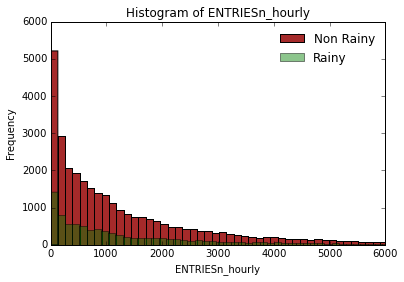

In [20]:
# Histogram - These plots have the same shape - and they are not normally distributed
plt.hist(norain['ENTRIESn_hourly'], bins=250, label='Non Rainy',color='brown')
plt.hist(rain['ENTRIESn_hourly'], bins=250, alpha=0.45, label='Rainy',color='green')
plt.title(r'Histogram of ENTRIESn_hourly')
plt.xlabel('ENTRIESn_hourly')
plt.ylabel('Frequency')
plt.legend(loc='best', frameon=False)
# resize to show the distribution of the data
plt.axis(xmin=0, xmax=6000)
plt.figure(figsize(10,5))


The histogram shows the distribution is non-normal for riders during rainy and non rainy days.  Skewed data often occur due to lower or upper bounds on the data. That is, data that have a lower bound are often skewed right while data that have an upper bound are often skewed left.  The rain and rainy day hourly entries are skewed to the left.

In [21]:
'''
 Shapiro-Wilks Test for normal distribution
 scipy.stats.shapiro(x, a=None, reta=False)[source]¶
 http://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm
 Returns:
 W : The test statistic.
 p-value : The p-value for the hypothesis test.
 a : array_like, optional
 
 The null-hypothesis of this test is that the population is normally distributed. 
 
 Thus if the p-value is less than the chosen alpha level, then the null hypothesis is 
 rejected and there is evidence that the data tested are not 
 from a normally distributed population. 
 
 In other words, the data are not normal. 
 
 On the contrary, if the p-value is greater than the chosen alpha level, 
 then the null hypothesis that the data came from a normally distributed 
 population cannot be rejected. 
 
 E.g. for an alpha level of 0.05, a data set with a p-value of 0.02 rejects 
 the null hypothesis that the data are from a normally distributed population.
 
 However, since the test is biased by sample size,[3] the test may be statistically 
 significant from a normal distribution in any large samples. 
 
 Thus a Q–Q plot is required for verification in addition to the test.
 
 Reference: https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test
 
'''
sharipo_results = stats.shapiro(df['ENTRIESn_hourly'], a=None, reta=True)
print 'W Statistic %.3f \np-value: %.3f' % (sharipo_results[0], sharipo_results[1])
print 'The data tested are not from a normally distributed population'

W Statistic 0.594 
p-value: 0.000
The data tested are not from a normally distributed population


/home/cnicholson/anaconda/lib/python2.7/site-packages/scipy/stats/morestats.py:997: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### 1.3 What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.

In [22]:
print '\n'
print 'TABLE 1.0 - MANN WHITNEY U-Test'
print '\n'
print 'DESCRIPTIVE STATISTICS'
print '\t\tn \t\tmean \t\tmedian \t\tStDev \t\tSE Mean'
print 'Rain   \t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (rain_n,rain_xbar, rain_median,rain_sd,rain_se)
print 'No Rain\t\t%.2f \t%.2f \t%.2f \t\t%.2f \t%.2f' % (norain_n,norain_xbar,norain_median,norain_sd,norain_se)
print '\n'

print 'INFERENTIAL STATISTICS'
# Paired t-test, two tail, t-statistic ,df,p-value, direction of test (two tail, or one tail to in _/- directrion')
print 'Type of test\t\t\t = %s' % 'Mann Whitney U-test'
print 'Test statistics: U \t\t = %.0f' % u_statistic
#print 'Degrees of Freedom\t\t = %.0f' % ((rain_n+norain_n)-2)
print 'Significance Level: alpha \t = %s ' % '0.01'
#print 'Critical value: t1-α/2,ν \t = %.3f' % critical_value
#print 'Critical region: Reject H0 if \t = |T| > %.3f' % critical_value
print 'P-Value\t\t\t\t = %.9f' % (mannwhitney_p_value*2)
print 'Direction of test\t\t = %s ' % 'two tail'
print '\n'



TABLE 1.0 - MANN WHITNEY U-Test


DESCRIPTIVE STATISTICS
		n 		mean 		median 		StDev 		SE Mean
Rain   		9585.00 	2028.20 	939.00 		3189.43 	3189.27
No Rain		33064.00 	1845.54 	893.00 		2878.77 	2878.73


INFERENTIAL STATISTICS
Type of test			 = Mann Whitney U-test
Test statistics: U 		 = 153635120
Significance Level: alpha 	 = 0.01 
P-Value				 = 0.000005482
Direction of test		 = two tail 




### 1.4 What is the significance and interpretation of these results?


### Mann Whitney U Test

We can reject the null hypothesis.  

- The median for Rain is larger than No Rain median.
- U Statistic = 153635120, p < 0.001  
- P-Value				 = 0.000005482


Median latencies in groups Rain and No Rain were 939 and 893 hourly entries; the distributions in the two groups differed significantly (Mann–Whitney U = 153,635,120, n(rain) = 9584, n(no rain)= 33064, P < 0.05 two-tailed).



## Section 2. Linear Regression


### 2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model: OLS using Statsmodels or Scikit Learn Gradient descent using Scikit Learn Or something different?

The OLS method from Statsmodels is used to compute the coefficients that and produce predictions for the ENTRIES_hourly.

In [23]:
values  = df['ENTRIESn_hourly']
features = df[["precipi","rain","hour","wspdi", "fog","tempi","pressurei"]]
# fog and rain show high p-values from the output dropping these and running the model again
#features = df[["hour","wspdi","pressurei"]]


dummy_units = pd.get_dummies(df['UNIT'], prefix='unit')
features = features.join(dummy_units)

dummy_units = pd.get_dummies(df['conds'], prefix='conds')
features = features.join(dummy_units)

dummy_units = pd.get_dummies(df['day_week'], prefix='dow')
features = features.join(dummy_units)

#dummy_units = pd.get_dummies(df['station'], prefix='station')
#features = features.join(dummy_units)
Y = values
X = features
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
intercept =  results.params[0]
params = results.params

intercept, params

print results.summary()
predictions = intercept + np.dot(features, params[1:])

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     153.9
Date:                Tue, 15 Sep 2015   Prob (F-statistic):               0.00
Time:                        09:54:29   Log-Likelihood:            -3.8700e+05
No. Observations:               42649   AIC:                         7.745e+05
Df Residuals:                   42385   BIC:                         7.768e+05
Df Model:                         263                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                   8285

### 2.2 What features (input variables) did you use in your model? 

In [24]:
results.params[:8]

const        8285.209460
precipi     -1371.611180
rain           37.875636
hour          119.153812
wspdi          17.431536
fog          -371.974689
tempi           2.701452
pressurei    -326.181030
dtype: float64

### Did you use any dummy variables as part of your features? 
Yes:
- UNIT
- conds
- day_week

A dummy variable is a categorical variable [in one column] which is converted into dummy/indicator variables.  What we do is transform or pivot the categorical variable from one column into many columns and the value in the column is either a 1 or 0 to inidicate if a row from this sample contains this dummy/indicator variable.

Hourly entries are associated to a turnstyle which can be located in a heavy populated area to a less populated area of New York.  Units in highly populated areas will be more popular, have more hourly entries than other units. 

Using the turnstyles as dummy variables one is able to make better predications.

Conditions were used as dummy variables as well as day of the week (M,T,W,Th, F, Sat, Sun) since rainy days are typically cloudy or another condition and weekend ridership is less on the weekends than weekdays.

**Example Conditions Coefficients:**  
conds_Clear: 695.0809   
conds_Fog: 1162.0372   
conds_Mist: 1406.2281    

**Example Day of the weekCoefficients:**   
dow_0: 1099.0852     
dow_1: 1450.2563   
dow_2: 1553.0466   
dow_3: 1594.1534   
dow_4: 1558.3367   
dow_5:  653.5154   
dow_6: 376.8159  
(0:N, 1:T, 2:W, 3:TH, 4:F, 5:S, 6:S)

Weekend days have a smaller coefficient.


**Example UNIT Dummy Variables:**  

unit_R012 is positive coefficeint while unit_R008 has a negative coefficent.
When unit_R012 is set to 1, meaning this row of data is at this turnstyle, we will add 6856 to the linear equation and the hourly entries.   The opposite will occur with unit_R008, we will subtract -1424 hourly entries when the row of data has a 1 value in the unit_R008 column's value.

Less popular stations/Units have a smaller or even negative coefficient.

In [25]:
results.params[12:20]

unit_R007   -1473.250608
unit_R008   -1456.005022
unit_R009   -1505.748840
unit_R011    5584.744426
unit_R012    6925.881311
unit_R013     824.322171
unit_R016    -988.375319
unit_R017    2439.316795
dtype: float64


### 2.3 Why did you select these features in your model? 

I reviewed the data and would remove and add features one at a time and observe the r-squared result and the residual plots.

Rain and meanprecipi were used because we are looking for the trend that rain causes more hourly entries and rain and the amount (average) rain during a time period can influcnce a person to ride the subway.   A light rain or sprinkle might also lead to more people riding the subway.

People ride the subway during all hours of the day but we have spikes in the morning and afternoon due to people commuting to New York so hour was used as part of the feature selection.

Ridership on the subway declines on the weekends therefore it is important to have the day of the week in the feature set so we can get more accurate predications since a weekday or 0 to 6 would have a coefficient.


### 2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model? 

In [26]:
results.params[:8]

const        8285.209460
precipi     -1371.611180
rain           37.875636
hour          119.153812
wspdi          17.431536
fog          -371.974689
tempi           2.701452
pressurei    -326.181030
dtype: float64

### 2.5 What is your model’s R2 (coefficients of determination) value?

In [27]:
# Validate the results from OLS, and just for myself to learn R-Square
SST = ((df['ENTRIESn_hourly']-np.mean(df['ENTRIESn_hourly']))**2).sum()
SSReg = ((predictions-df['ENTRIESn_hourly'])**2).sum()
r_squared = 1 - (SSReg/SST)
#print 'Validate R-Squared: \t%.3f' % r_squared

print 'OLS Models R-Squared: \t%.2f' % results.rsquared

OLS Models R-Squared: 	0.49


### 2.6 What does this R^2 value mean for the goodness of fit for your regression model?
R^2, the coefficient of determination with a range of 0 to 1, is a number that indicates how well data fit a statistical model.   In general the closer to 1 the better the model and the closer to 0 the poorer the model. 

The R^2 is a value of measure of goodness of fit of the mode so it can validate whether the model itself is a good model and R^2 does not explain anything about the effect of rain and the number of hourly entries.

The features chosen have explained 49% of the original variability and we are left with 51% residual variablility.

###  Do you think this linear model to predict ridership is appropriate for this dataset, given this R2 value?

Our model is appropriate and has room for improvement and/or is missing a feature (review the Predications vs Actual, and Predications vs Residuals) or the different population density areas need to be grouped into different datasets or samples.

#### Residual Plot - Histogram

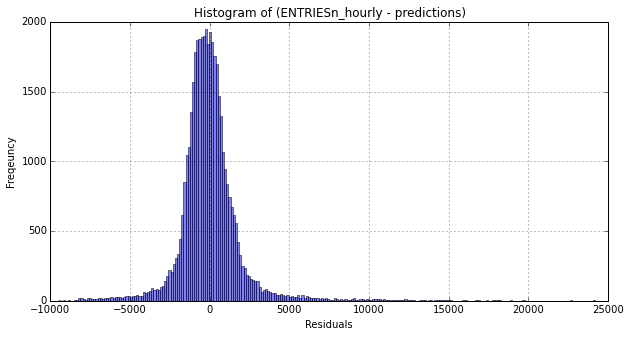

In [28]:
residuals = df['ENTRIESn_hourly'] - predictions 
# how can I be sure the dataframe and predications line up on the correct row
plt.figure()
residuals.hist(bins=250,alpha=0.5)
plt.title(r'Histogram of (ENTRIESn_hourly - predictions)')
plt.xlabel('Residuals')
plt.ylabel('Freqeuncy')

The following residuals plot is useful evidence for the linear regression model being appropriate. The distribution looks reasonably symmetric.

> “Residuals can be thought of as elements of variation unexplained by the fitted model. Since this is a form of error, the same general assumptions apply to the group of residuals that we typically use for errors in general: one expects them to be (roughly) normal and (approximately) independently distributed with a mean of 0 and some constant variance.” 


http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm 

In [29]:
'''
Testing how well the linear model performs
http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/
'''
# create a dataframe of the actual, predications and residuals
pd.options.mode.chained_assignment = None
cmpr = df[['UNIT', 'datetime','ENTRIESn_hourly' ]]
cmpr['predictions'] = predictions
cmpr['residuals'] = cmpr['ENTRIESn_hourly'] - cmpr['predictions']
cmpr['residuals_standardized'] = (cmpr['ENTRIESn_hourly'] - cmpr['predictions'])/np.sqrt(cmpr['predictions'])

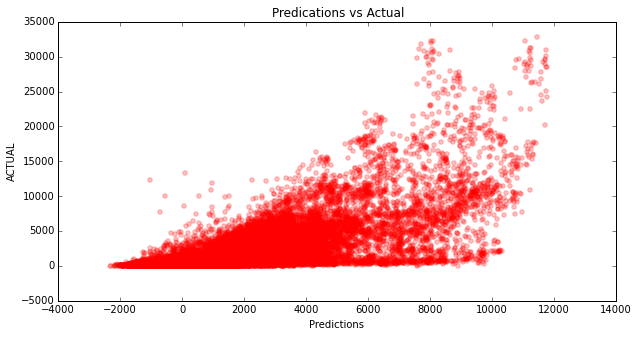

In [30]:
# create a dataframe of the actual, predications and residuals
a = plt.scatter(x=cmpr['predictions'], y=cmpr['ENTRIESn_hourly'], color='red', alpha=0.25)
plt.xlabel("Predictions")
plt.ylabel("ACTUAL")
plt.title("Predications vs Actual")

In this plot each point is one hourly predication, where the prediction made by the model is on the x-axis, and the Actual value of the hourly entry is on the y-axis. 

The model’s predictions aren’t very good at all once we start to model the higher number of hourly entries.

The model’s predictions start being very precise and as the model progresses we see a large variability as number of hourly entries increase.  This could be an affect of the variability in hourly entries (low and high values) for the different Units.

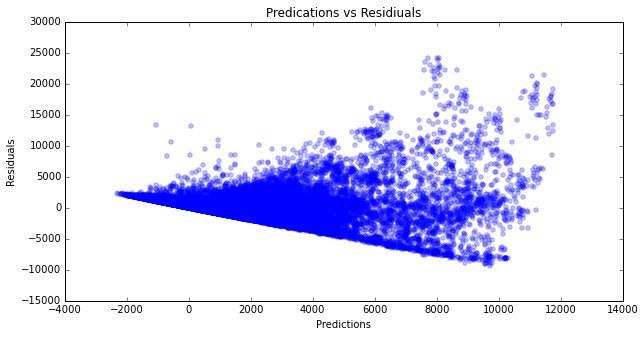

In [31]:
# create a dataframe of the predications and residuals
a = plt.scatter(x=cmpr['predictions'], y=cmpr['residuals'], color='blue', alpha=0.25)
plt.xlabel("Predictions")
plt.ylabel("Residuals")
plt.title("Predications vs Residiuals")

Residual = Observed – Predicted  

In this plot  each point is one hourly predication, where the prediction made by the model is on the x-axis, and the accuracy of the prediction is on the y-axis. The distance from the line at 0 is how bad the prediction was for that value.



Positive values for the residual (on the y-axis) mean the prediction was too low, and negative values mean the prediction was too high; 0 means the guess was exactly correct.

As the Predications (Hourly Entries) increases we see we have less precise predications.

## Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.  

Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.



### 3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.

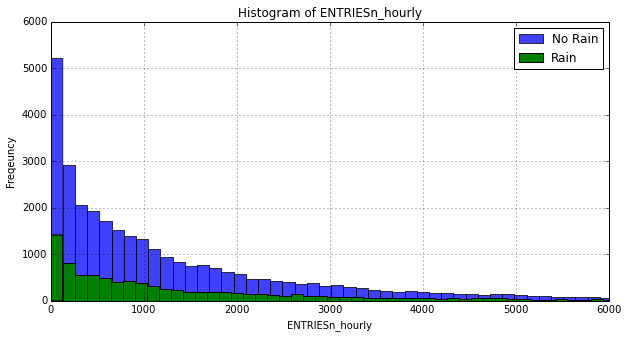

In [32]:
plt.figure()
#bins
binSize = 250
# your code here to plot a historgram for hourly entries when it is not raining
norain['ENTRIESn_hourly'].hist(color='blue', label='No Rain', bins=binSize,alpha=0.75)
# your code here to plot a historgram for hourly entries when it is raining
rain['ENTRIESn_hourly'].hist(color='green',label='Rain',bins=binSize)
plt.legend()
plt.title(r'Histogram of ENTRIESn_hourly')
plt.xlabel('ENTRIESn_hourly')
plt.xlim(0,6000)
plt.ylabel('Freqeuncy')


The histogram shows the distribution is non-normal for riders during rainy and non rainy days.  Skewed data often occur due to lower or upper bounds on the data. That is, data that have a lower bound are often skewed right while data that have an upper bound are often skewed left.  The rain and rainy day hourly entries are skewed to the left.

## 3.2 One visualization can be more freeform. 

You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
Ridership by time-of-day
Ridership by day-of-week

In [33]:
# Add the day as interger
def datetime_to_day(string_data):
    d = datetime.datetime.strptime(string_data, '%Y-%m-%d %H:%M:%S')
    return int(d.day)

# Add the hours as an interger
def datetime_to_hour_of_day(string_data):
    #d = datetime.datetime.strptime(string_data, '%Y-%m-%d %H:%M:%S')
    d = dateti
    (d.hour)

rain['day'] = rain['datetime'].map(datetime_to_day)
rain['iHour'] = rain['TIMEn'].map(datetime_to_hour_of_day)

norain['day'] = norain['datetime'].map(datetime_to_day)
norain['iHour'] = norain['TIMEn'].map(datetime_to_hour_of_day)

NameError: global name 'dateti' is not defined

In [ ]:
# note it might not rain the entire day, or it could rain during periods of low activity
wd = df[df['weekday']==1]
we = df[df['weekday']==0]

wd['day'] = wd['datetime'].map(datetime_to_day)
we['day'] = we['datetime'].map(datetime_to_day)

wd = wd.groupby('day', as_index=True).mean()
wd = wd.reset_index()

we = we.groupby('day', as_index=True).mean()
we = we.reset_index()

fig, ax = plt.subplots()
index = array(numpy.arange(1,32))
#bar_width = 0.35
opacity = 0.8

p1 = plt.bar(wd['day'], wd['ENTRIESn_hourly'], 
                 alpha=opacity,
                 color='gray',
                 label='Weekday')

p2 = plt.bar(we['day'], we['ENTRIESn_hourly'],
                 alpha=opacity,
                 color='yellow',
                 label='Weekend')

plt.xlabel('Day of the Month (May 2011)')
plt.ylabel('ENTRIESn_hourly')
plt.title('Bar Plot of Mean Hourly Entries for Weekday & Weekend')
plt.legend(loc='best', frameon=False)
xticks( index )
plt.tight_layout()
plt.show()

The plot shows a marked decrease on Subway rides during the weekend. 
Note, if we had more rain days for the dataset during weekends this will affect the distribution, and we should probably remove weekend days from the main dataset when testing for rain vs. no rainy days.   
 
A weekday is not equal to weekend subway use patterns. 

## Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

### 4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?

People ride the subway more when it is raining based on the above analysis.

### 4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

####Mann Whitney U test 

Median latencies in groups Rain and No Rain were 939 and 893 hourly entries; the distributions in the two groups differed significantly (Mann–Whitney U = 153,635,120, n(rain) = 9584, n(no rain)= 33064, P < 0.05 two-tailed).

#### Additional Support

Also the **rain coefficient** from the linear regression is a postive value, which means when we have rain the value is 1 the positive value coefficent is multipled by (1), which increases the hourly entry predications.  The **cond_Mist** coefficient was positive as well which also demonstrates a when the condition is misting we will have more hourly entries.

Review section 2.1 and 2.2 for additional coefficients.



## Section 5. Reflection

### 5.1 Please discuss potential shortcomings of the methods of your analysis, including: 

#### Dataset

The	dataset	consisted of one month of subway riders	with hourly	entries. Having	more data than one month would be beneficial. Three	years of data would	provide	a good start to	compare	like days, months, temperature,	rainy days,	and	holidays.  We	should	rethink	the	analysis to	 remove	the	weekend	days from the analysis since the total number of riders for a	weekend	could shift	the	mean.


#### Linear	Regression Model

I think the linear model is	adequate base on the residual plots of the hourly entries.  Weekends and Holidays have different use patterns, and locations of turnstiles have different use patterns. Some entries and exits may occur without the person being	above ground our outside. (One could ride the rain from Connecticut, exit at Grand Central and then	re-enter the Subway).

With respect to	the linear regression model the ridership of the subway	might find a better fit	with a non-linear model.  This leads us to believe our model is missing a variable or we need to split the data apart and see if we can group stations or turnstyles into more normalized groups.		


### 5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

May 14-20th was a very rainy set of consectutive days for NYC.

# Referenecs

Python 3.4.2 Documentation     
Retrieved from https://docs.python.org/

ggplot from yhat   
Retrieved from http://ggplot.yhathq.com/

SciPy.org    
Retrieved from http://scipy.org/

Engineering Statistics    
Retrieved from http://www.itl.nist.gov/div898/handbook/

5.2.4.  Are the model residuals well-behaved? [Blog Post]   
Retrieved from http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm

The Minitab Blog What Is the Difference between Linear and Nonlinear Equations in Regression Analysis? [Blog Post]  
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics 

The Minitab Blog Regression Analysis how do I interpret R Squared and assess the goodness of fit. [Blog Post]  
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

What are the differences between one-tailed and two-tailed tests? [Blog Post]   
Retrieved from http://www.ats.ucla.edu/stat/mult_pkg/faq/general/tail_tests.htm

Dummy Variables [Wiki Post]   
Retrieved from http://en.wikipedia.org/wiki/Dummy_variable_(statistics) 

Mann-Whitney U Test using SPSS [Blog Post]   
Retrieved from https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.phpRegression 

Independent T-Test for Two Samples [Blog Post]   
Retrieved from https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php

Analysis – How to Interpret the Constant Y Intercept [Blog Post]   
Retrieved from http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept 

Coding in the Rain [Blog Post]   
Retrieved From http://drjasondavis.com/2013/07/08/coding-in-the-rain/ 

Mann-Whitney U Test using SPSS  
Retrieved From https://statistics.laerd.com/spss-tutorials/mann-whitney-u-test-using-spss-statistics.php